# Movie Lens Dataset

The Movie Lens Dataset is one of the most common datasets that is available on the internet for building a Recommender System. The Movies Lens dataset contain 3 files with 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000. 
Permalink: https://grouplens.org/datasets/movielens/1m/


In this spotlight, I am going to explore the Movie Lens dataset, and build a recommendation systems. I will apply content-based and memory-based collaboratice filtering, SVD, and Machine Learning approach on the Movie Lens datasets using python built-in packages and tools including the dimension reduction tool in scikit learn package. In the end, I will summarize and compare the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import statistics as stat
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Users Dataset

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [2]:
users = pd.read_csv('./users.dat',  sep='::', 
                    engine='python', 
                    encoding='ISO-8859-1',
                    names=['UserID','Gender','Age','Occupation','Zip-code'])

In [3]:
print(users.iloc[:10])

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455
5       6      F   50           9    55117
6       7      M   35           1    06810
7       8      M   25          12    11413
8       9      M   25          17    61614
9      10      F   35           1    95370


In [4]:
len(users)

6040

## Movies Dataset

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [5]:
movies = pd.read_csv('./movies.dat', sep='::', 
                    engine='python', 
                    encoding='ISO-8859-1',
                    names=['MovieID', 'Title', 'Genres'])

In [6]:
print(movies.iloc[:10])

   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
5        6                         Heat (1995)         Action|Crime|Thriller
6        7                      Sabrina (1995)                Comedy|Romance
7        8                 Tom and Huck (1995)          Adventure|Children's
8        9                 Sudden Death (1995)                        Action
9       10                    GoldenEye (1995)     Action|Adventure|Thriller


In [7]:
len(movies)

3883

## Ratings Dataset

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings


In [8]:
ratings = pd.read_csv('./ratings.dat',  sep='::', 
                    engine='python', 
                    encoding='ISO-8859-1',
                    names=['UserID','MovieID','Rating','Timestamp'])

In [9]:
print(ratings.iloc[:10])

   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
5       1     1197       3  978302268
6       1     1287       5  978302039
7       1     2804       5  978300719
8       1      594       4  978302268
9       1      919       4  978301368


In [10]:
len(ratings)

1000209

### Data Exploration

In [11]:
ratings['Rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

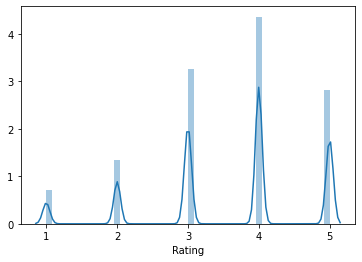

In [12]:
import seaborn as sns
# Display distribution of rating
sns.distplot(ratings['Rating'])

(array([ 56174.,      0., 107557.,      0.,      0., 261197.,      0.,
        348971.,      0., 226310.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

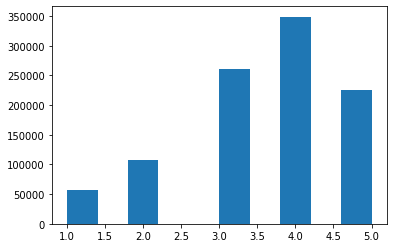

In [13]:
plt.hist(ratings['Rating'],10)

(array([300288., 281379., 349979.,  17950.,  14339.,   9656.,   9539.,
          6274.,   5437.,   5368.]),
 array([9.56703932e+08, 9.65678998e+08, 9.74654064e+08, 9.83629129e+08,
        9.92604195e+08, 1.00157926e+09, 1.01055433e+09, 1.01952939e+09,
        1.02850446e+09, 1.03747952e+09, 1.04645459e+09]),
 <a list of 10 Patch objects>)

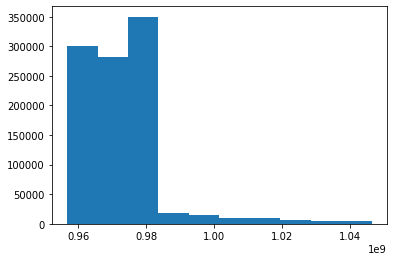

In [14]:
plt.hist(ratings['Timestamp'],10)

# Content-Based and Collaborative Filtering Recommender System
Two most ubiquitous types of personalized recommendation systems are **Content-Based** and **Collaborative Filtering**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

## Content-Based Recommendation Model
### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).


After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.



Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. To do so, I will make use of the file **movies.csv**.

In [15]:
# Break up the genre string into a string array
movies['Genres'] = movies['Genres'].str.split('|')
type(movies['Genres'])

pandas.core.series.Series

In [16]:
print(movies.iloc[:10])

   MovieID                               Title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                             Genres  
0   [Animation, Children's, Comedy]  
1  [Adventure, Children's, Fantasy]  
2                 [Comedy, Romance]  
3                   [Comedy, Drama]  
4                          [Comedy]  
5         [Action, Crime, Thriller]  
6                 [Comedy, Romance]  
7           [Adventure, Children's]  
8                          [Action]  
9     [Action, Adventure, Thriller]  


In [17]:
movies['Genres'] = movies['Genres'].fillna('').astype('str')

In [18]:
print(movies.iloc[:10])

   MovieID                               Title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                   Genres  
0   ['Animation', "Children's", 'Comedy']  
1  ['Adventure', "Children's", 'Fantasy']  
2                   ['Comedy', 'Romance']  
3                     ['Comedy', 'Drama']  
4                              ['Comedy']  
5         ['Action', 'Crime', 'Thriller']  
6                   ['Comedy', 'Romance']  
7             ['Adventure', "Children's"]  
8                              ['Action']  
9     ['A

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2), stop_words='english')
Tfidf_matrix = Tfidf.fit_transform(movies['Genres'])
Tfidf_matrix.shape

(3883, 127)

In [20]:

# get the first vector out (for the first document)
first_vector_tfidfvectorizer=Tfidf_matrix[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(Tfidf_matrix.T.todense(), index=Tfidf.get_feature_names())

df

,0,1,2,3,4,5,6,7,8,9,...,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882
action,0.000000,0.000000,0.000000,0.0,0.0,0.305869,0.000000,0.000000,1.0,0.312081,...,0.0,0.0,0.000000,0.365082,0.0,0.0,0.0,0.0,0.0,0.000000
action adventure,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.451885,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
action animation,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
action children,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
action comedy,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
action crime,0.000000,0.000000,0.000000,0.0,0.0,0.563171,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
action drama,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.596960,0.0,0.0,0.0,0.0,0.0,0.000000
action horror,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
action mystery,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
action romance,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [21]:
print(Tfidf_matrix)

  (0, 38)	0.5109293383032849
  (0, 30)	0.521820712785304
  (0, 45)	0.23523321955508567
  (0, 37)	0.40421250853461244
  (0, 29)	0.49792764065786643
  (1, 40)	0.5646685040193531
  (1, 16)	0.46761690015763424
  (1, 83)	0.472914594270857
  (1, 14)	0.3399040198123365
  (1, 37)	0.35114236300474577
  (2, 54)	0.7438770188400547
  (2, 114)	0.547641831333837
  (2, 45)	0.3830605766911466
  (3, 48)	0.8043126940615187
  (3, 72)	0.38922070282647575
  (3, 45)	0.44898589583946386
  (4, 45)	1.0
  (5, 67)	0.5830617543263168
  (5, 5)	0.5631709259314428
  (5, 121)	0.30808790652703055
  (5, 59)	0.3929420073499535
  (5, 0)	0.3058691215847394
  (6, 54)	0.7438770188400547
  (6, 114)	0.547641831333837
  (6, 45)	0.3830605766911466
  :	:
  (3870, 94)	1.0
  (3871, 94)	1.0
  (3872, 94)	1.0
  (3873, 45)	1.0
  (3874, 48)	0.8043126940615187
  (3874, 72)	0.38922070282647575
  (3874, 45)	0.44898589583946386
  (3875, 15)	0.6129096681522606
  (3875, 14)	0.3379914406520223
  (3875, 30)	0.4507587789901497
  (3875, 37)	0.34

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [22]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(Tfidf_matrix, Tfidf_matrix)
cosine_sim[:4, :4]
 

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [29]:
# Build a 1-dimensional array with movie titles
titles = movies['Title']
indices = pd.Series(movies.index, index=movies['Title'])
movieIDs=movies['MovieID']
genres=movies['Genres']
# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:30]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices]

Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [30]:
genre_recommendations('Good Will Hunting (1997)')

,MovieID,Title,Genres
13,14,Nixon (1995),['Drama']
25,26,Othello (1995),['Drama']
26,27,Now and Then (1995),['Drama']
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,['Drama']
30,31,Dangerous Minds (1995),['Drama']
35,36,Dead Man Walking (1995),['Drama']
39,40,"Cry, the Beloved Country (1995)",['Drama']
42,43,Restoration (1995),['Drama']
52,53,Lamerica (1994),['Drama']
54,55,Georgia (1995),['Drama']


In [31]:
genre_recommendations('Saving Private Ryan (1998)')

,MovieID,Title,Genres
108,110,Braveheart (1995),"['Action', 'Drama', 'War']"
461,465,Heaven & Earth (1993),"['Action', 'Drama', 'War']"
1204,1222,Full Metal Jacket (1987),"['Action', 'Drama', 'War']"
1214,1233,"Boat, The (Das Boot) (1981)","['Action', 'Drama', 'War']"
1222,1242,Glory (1989),"['Action', 'Drama', 'War']"
1545,1586,G.I. Jane (1997),"['Action', 'Drama', 'War']"
1959,2028,Saving Private Ryan (1998),"['Action', 'Drama', 'War']"
2358,2427,"Thin Red Line, The (1998)","['Action', 'Drama', 'War']"
2993,3062,"Longest Day, The (1962)","['Action', 'Drama', 'War']"
3559,3628,Flying Tigers (1942),"['Action', 'Drama', 'War']"


Overall, here are the pros of using content-based recommendation:
* No need for data on other users, thus no cold-start or sparsity problems.
* Can recommend to users with unique tastes.
* Can recommend new & unpopular items.
* Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

However, there are some cons of using this approach:
* Finding the appropriate features is hard.
* Does not recommend items outside a user's content profile.
* Unable to exploit quality judgments of other users.

## Collaborative Filtering Recommendation Model
The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to movie users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

### Theory
There are 2 main types of memory-based collaborative filtering algorithms:
1. **User-User Collaborative Filtering**: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.
2. **Item-Item Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.



In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the **user-similarity matrix** will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the **item-similarity matrix** will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:
1. **Jaccard Similarity**:
    * Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
    * It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

2. **Cosine Similarity**: (as in the Content-Based system)
    * Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
    * Closer the vectors, smaller will be the angle and larger the cosine

3. **Pearson Similarity**:
    * Similarity is the pearson coefficient between the two vectors.

For the purpose of diversity, I will use **Pearson Similarity** in this implementation.

### Implementation
I will use the file **ratings.csv** first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie.

First I do some quick data processing:

In [32]:
# Fill NaN values in user_id and movie_id column with 0
ratings['UserID'] = ratings['UserID'].fillna(0)
ratings['MovieID'] = ratings['MovieID'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['Rating'] = ratings['Rating'].fillna(ratings['Rating'].mean())

In [33]:
# Randomly sample 1% of the ratings dataset
small_data = ratings.sample(frac=0.02)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 649637 to 847363
Data columns (total 4 columns):
UserID       20004 non-null int64
MovieID      20004 non-null int64
Rating       20004 non-null int64
Timestamp    20004 non-null int64
dtypes: int64(4)
memory usage: 781.4 KB
None


In [34]:
ratings.head(10)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [35]:

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(small_data, test_size=0.2)

Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [36]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['UserID', 'MovieID', 'Rating'])
test_data_matrix = test_data.as_matrix(columns = ['UserID', 'MovieID', 'Rating'])


/Users/pinglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/pinglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
train_data_matr=train_data[['UserID','MovieID','Rating']]
#print(train_data_matr)

Now I use the **pairwise_distances** function from sklearn to calculate the [Pearson Correlation Coefficient](https://stackoverflow.com/questions/1838806/euclidean-distance-vs-pearson-correlation-vs-cosine-similarity). This method provides a safe way to take a distance matrix as input, while preserving compatibility with many other algorithms that take a vector array.

In [38]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
#user_correlation[np.isnan(user_correlation)] = 0


Try Cosine Similarity Score for Users

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
user_correlation_Cosi= cosine_similarity(train_data)

In [41]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
#item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.         -0.01506435  0.00595536]
 [-0.01506435  1.         -0.06042309]
 [ 0.00595536 -0.06042309  1.        ]]


In [42]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is **Root Mean Squared Error (RMSE)**. I will use the **mean_square_error (MSE)** function from sklearn, where the RMSE is just the square root of MSE.

$$\mathit{RMSE} =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$

I'll use the scikit-learn's **mean squared error** function as my validation metric. 

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [44]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1375.8431042341797
Item-based CF RMSE: 1654.9602496189873


In [45]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 969.228170030572
Item-based CF RMSE: 139.76970335596536


RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. I noticed that my RMSE is quite big. I suppose I might have overfitted the training data.

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

* It doesn't address the well-known cold-start problem, that is when new user or new item enters the system. 
* It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
* It suffers when new users or items that don't have any ratings enter the system.
* It tends to recommend popular items.

## SVD for Movie Recommendations
Memory-based collaborative filtering approaches that compute distance relationships between items or users have these two major issues:

1. It doesn't scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities - which takes a lot of computations.
2. Ratings matrices may be overfitting to noisy representations of user tastes and preferences. When we use distance based "neighborhood" approaches on raw data, we match to sparse low-level details that we assume represent the user's preference vector instead of the vector itself.

Thus I'd need to apply **Dimensionality Reduction** technique to derive the tastes and preferences from the raw data, otherwise known as doing low-rank matrix factorization. Why reduce dimensions?

* I can discover hidden correlations / features in the raw data.
* I can remove redundant and noisy features that are not useful.
* I can interpret and visualize the data easier.
* I can also access easier data storage and processing.

The Singular Vector Decomposition (SVD) is a powerful dimensionality reduction technique that is used heavily in modern model-based CF recommender system.


In [46]:
n_users = ratings.UserID.unique().shape[0]
n_movies = ratings.MovieID.unique().shape[0]
print( "Number of unique Users in ratings.dat file = " +str(n_users)+ ", Number of unique movies in ratings.dat file=" + str(n_movies))

Number of unique Users in ratings.dat file = 6040, Number of unique movies in ratings.dat file=3706


Now I want the format of my ratings matrix to be one row per user and one column per movie. To do so, I'll pivot *ratings* to get that and call the new variable *Ratings* (with a capital *R).

In [47]:
Ratings = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
Ratings

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


I need to normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [48]:
R = Ratings.as_matrix()


/Users/pinglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [49]:
R

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [50]:
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [51]:
Ratings_demeaned

array([[ 4.94009714, -0.05990286, -0.05990286, ..., -0.05990286,
        -0.05990286, -0.05990286],
       [-0.12924987, -0.12924987, -0.12924987, ..., -0.12924987,
        -0.12924987, -0.12924987],
       [-0.05369671, -0.05369671, -0.05369671, ..., -0.05369671,
        -0.05369671, -0.05369671],
       ...,
       [-0.02050729, -0.02050729, -0.02050729, ..., -0.02050729,
        -0.02050729, -0.02050729],
       [-0.1287102 , -0.1287102 , -0.1287102 , ..., -0.1287102 ,
        -0.1287102 , -0.1287102 ],
       [ 2.6708041 , -0.3291959 , -0.3291959 , ..., -0.3291959 ,
        -0.3291959 , -0.3291959 ]])

## Model-Based Collaborative Filtering
*Model-based Collaborative Filtering* is based on *matrix factorization (MF)* which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

* The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. 
* When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. 
* You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

For example, let's check the sparsity of the ratings dataset:

In [52]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print ('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 95.5%


## Support Vector Decomposition (SVD)
A well-known matrix factorization method is *Singular value decomposition (SVD)*. At a high level, SVD is an algorithm that decomposes a matrix $A$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:

![svd](svd.png)

where $A$ is the input data matrix (users's ratings), $U$ is the left singular vectors (user "features" matrix), $\Sigma$ is the diagonal matrix of singular values (essentially weights/strengths of each concept), and  $V^{T}$ is the right singluar vectors (movie "features" matrix). $U$ and $V^{T}$ are column orthonomal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, I take these matrices and keep only the top $k$ features, which can be thought of as the underlying tastes and preferences vectors.

### Setting Up SVD
Scipy and Numpy both have functions to do the singular value decomposition. I'm going to use the Scipy function *svds* because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [53]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [54]:
U

array([[-4.97801875e-03,  5.86971868e-03, -1.18186843e-02, ...,
        -2.95139320e-03,  1.95703358e-03,  5.46889776e-03],
       [-1.10526375e-03, -4.04545890e-03,  1.16776791e-02, ...,
        -9.18855171e-04, -2.17034433e-03,  1.04359614e-02],
       [ 9.44963839e-03, -1.43519545e-02, -3.93638119e-04, ...,
         2.89764529e-03, -2.86504507e-03,  6.13985002e-03],
       ...,
       [-1.05731072e-02, -6.80807641e-03, -2.63392883e-03, ...,
         4.84286245e-05,  1.89077440e-03,  1.52456048e-03],
       [ 6.34420788e-03, -9.45269844e-03,  2.69929558e-03, ...,
         1.07208981e-02,  1.88878158e-02,  6.87143535e-03],
       [-1.84854679e-02,  1.28388950e-02,  8.46988257e-03, ...,
         1.89987575e-03,  4.15563933e-02,  1.92850979e-02]])

In [55]:
U.shape

(6040, 50)

In [56]:
Vt

array([[-0.07028629,  0.02415349, -0.01883837, ...,  0.00380736,
        -0.00049127,  0.00061123],
       [ 0.03681506,  0.00346263, -0.01264234, ..., -0.00965995,
        -0.00513455, -0.02377963],
       [ 0.03495646,  0.00904907,  0.00823098, ...,  0.00157338,
        -0.00234513,  0.00802561],
       ...,
       [-0.03287652,  0.01185799, -0.01107445, ..., -0.00114772,
        -0.00294575, -0.02222119],
       [-0.01776333, -0.03068092, -0.01786526, ...,  0.00087071,
         0.0012666 ,  0.00435186],
       [ 0.07625855,  0.01650222,  0.00468327, ..., -0.00852744,
        -0.01020778,  0.00425656]])

In [57]:
Vt.shape

(50, 3706)

As I'm going to leverage matrix multiplication to get predictions, I'll convert the  Σ  (now are values) to the diagonal matrix form.

In [58]:
sigmaM = np.diag(sigma)

In [59]:
sigma

array([ 147.18581225,  147.62154312,  148.58855276,  150.03171353,
        151.79983807,  153.96248652,  154.29956787,  154.54519202,
        156.1600638 ,  157.59909505,  158.55444246,  159.49830789,
        161.17474208,  161.91263179,  164.2500819 ,  166.36342107,
        166.65755956,  167.57534795,  169.76284423,  171.74044056,
        176.69147709,  179.09436104,  181.81118789,  184.17680849,
        186.29341046,  192.15335604,  192.56979125,  199.83346621,
        201.19198515,  209.67692339,  212.55518526,  215.46630906,
        221.6502159 ,  231.38108343,  239.08619469,  244.8772772 ,
        252.13622776,  256.26466285,  275.38648118,  287.89180228,
        315.0835415 ,  335.08085421,  345.17197178,  362.26793969,
        415.93557804,  434.97695433,  497.2191638 ,  574.46932602,
        670.41536276, 1544.10679346])

In [60]:
len(sigma)

50

In [61]:
sigmaM

array([[ 147.18581225,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  147.62154312,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,  148.58855276, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  574.46932602,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
         670.41536276,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1544.10679346]])

### Making Predictions from the Decomposed Matrices
I now have everything I need to make movie ratings predictions for every user. I can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$.

But first, I need to add the user means back to get the actual star ratings prediction.

In [62]:
all_user_predicted_ratings = np.dot(np.dot(U, sigmaM), Vt) + user_ratings_mean.reshape(-1, 1)

In [63]:
all_user_predicted_ratings

array([[ 4.28886061,  0.14305516, -0.1950795 , ...,  0.03191195,
         0.05044975,  0.08891033],
       [ 0.74471587,  0.16965927,  0.33541808, ..., -0.10110207,
        -0.0540982 , -0.14018846],
       [ 1.81882382,  0.45613623,  0.09097801, ...,  0.01234452,
         0.01514752, -0.10995596],
       ...,
       [ 0.61908871, -0.16176859,  0.10673806, ..., -0.01336948,
        -0.0303543 , -0.11493552],
       [ 1.50360483, -0.03620761, -0.16126817, ..., -0.01090407,
        -0.03864749, -0.16835943],
       [ 1.99624816, -0.18598715, -0.1564782 , ..., -0.00664061,
         0.12706713,  0.28500112]])

With the predictions matrix for every user, I can build a function to recommend movies for any user. I return the list of movies the user has already rated, for the sake of comparison.

In [64]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)

In [65]:
preds.iloc[:99,:93]

MovieID,1,2,3,4,5,6,7,8,9,10,...,85,86,87,88,89,90,92,93,94,95
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,-0.189733,0.057086,0.023608,-0.154850,-0.002391,0.005890,-0.010414,-0.029962,0.021119,0.032702
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.019091,0.126839,-0.024443,0.037234,0.257045,0.017242,-0.032966,0.017443,-0.026824,0.874082
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,-0.088931,0.261054,-0.027219,-0.024619,0.034167,0.007712,0.079410,0.014448,-0.045123,0.241380
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.025352,0.008961,0.022604,0.164667,-0.072729,-0.005926,-0.020252,0.010712,-0.015150,-0.126137
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.793463,0.121629,0.044270,-0.086584,-0.012179,0.045015,-0.039424,-0.012038,0.229447,0.123968
5,2.080954,0.200896,0.257427,0.071778,0.188707,0.141861,0.682232,0.024831,-0.028948,0.215784,...,0.085061,-0.051614,-0.014025,-0.006391,-0.047360,0.000188,0.046673,0.031968,-0.063031,-0.027090
6,0.050561,0.145551,0.071439,0.030906,-0.063137,1.535804,-0.113641,0.003906,-0.036238,1.229246,...,-0.035394,-0.034241,0.013118,-0.067444,0.130674,0.006425,-0.043412,-0.060262,0.040576,0.370655
7,0.818760,0.157268,0.691568,0.335525,-0.082421,1.705631,0.234284,0.003777,0.077987,0.601926,...,0.516253,0.381344,-0.047778,0.048012,0.203156,0.052462,0.116929,0.017278,0.528468,0.278284
8,3.667258,0.125559,0.025810,-0.039819,-0.083895,0.950044,0.108963,0.007310,-0.024961,-0.069152,...,-0.088933,0.030991,-0.039001,0.074536,-0.069851,0.002360,-0.010893,-0.024214,0.147699,-0.124916
9,4.516912,2.968196,1.254102,0.378729,1.123322,-0.981174,1.934979,0.292535,-0.008434,0.942800,...,-0.131758,0.333232,0.092441,0.337651,-0.054801,-0.026288,0.134290,0.131693,0.321236,0.284274


In [66]:
preds

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244
5,2.080954,0.200896,0.257427,0.071778,0.188707,0.141861,0.682232,0.024831,-0.028948,0.215784,...,0.038648,0.002989,0.020866,0.063753,-0.017803,0.791963,0.155650,0.017319,0.024461,0.328527
6,0.050561,0.145551,0.071439,0.030906,-0.063137,1.535804,-0.113641,0.003906,-0.036238,1.229246,...,-0.043208,0.005675,0.008339,0.061346,-0.014502,0.530467,-0.278626,-0.064967,-0.023494,0.067700
7,0.818760,0.157268,0.691568,0.335525,-0.082421,1.705631,0.234284,0.003777,0.077987,0.601926,...,-0.076979,0.012318,-0.005415,-0.096365,-0.073352,-0.003274,0.277892,-0.034586,-0.010906,-0.034938
8,3.667258,0.125559,0.025810,-0.039819,-0.083895,0.950044,0.108963,0.007310,-0.024961,-0.069152,...,0.062487,0.001016,0.024406,0.043398,-0.010220,1.497517,0.317699,0.079573,-0.001441,0.614613
9,4.516912,2.968196,1.254102,0.378729,1.123322,-0.981174,1.934979,0.292535,-0.008434,0.942800,...,-0.010326,-0.004641,0.043944,-0.084057,-0.058872,0.857068,0.218063,0.022517,-0.000597,0.029621


Now I will write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

In [67]:
def recommend_movies(userID, num_recommendations):
    
    # Get and sort the user's predictions

    user_row_number = userID - 1
    
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) 
    
    # Get the user's data and merge in the movie information.
    user_data = ratings[ratings.UserID == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'MovieID', right_on = 'MovieID').sort_values(['Rating'], ascending=False)
                )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['MovieID'].isin(user_full['MovieID'])].
                       merge(pd.DataFrame(sorted_user_predictions).reset_index(), 
                             how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                       rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      )

    return recommendations

In [68]:
def already_rated_movies(userID):
    
    # Get and sort the user's predictions

    user_row_number = userID - 1
    
    
    user_data = ratings[ratings.UserID == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'MovieID', right_on = 'MovieID').sort_values(['Rating'], ascending=False)
                )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    return user_full

In [69]:
already_rated_movies(100)

User 100 has already rated 76 movies.


,UserID,MovieID,Rating,Timestamp,Title,Genres
1,100,800,5,977593915,Lone Star (1996),"['Drama', 'Mystery']"
63,100,527,5,977594839,Schindler's List (1993),"['Drama', 'War']"
16,100,919,5,977594947,"Wizard of Oz, The (1939)","['Adventure', ""Children's"", 'Drama', 'Musical']"
17,100,924,4,977594873,2001: A Space Odyssey (1968),"['Drama', 'Mystery', 'Sci-Fi', 'Thriller']"
29,100,969,4,977594044,"African Queen, The (1951)","['Action', 'Adventure', 'Romance', 'War']"
22,100,2406,4,977594142,Romancing the Stone (1984),"['Action', 'Adventure', 'Comedy', 'Romance']"
47,100,318,4,977594839,"Shawshank Redemption, The (1994)",['Drama']
20,100,858,4,977593950,"Godfather, The (1972)","['Action', 'Crime', 'Drama']"
49,100,329,4,977594297,Star Trek: Generations (1994),"['Action', 'Adventure', 'Sci-Fi']"
50,100,260,4,977593595,Star Wars: Episode IV - A New Hope (1977),"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']"


In [70]:
recommend_movies(100, 20)

User 100 has already rated 76 movies.
Recommending highest 20 predicted ratings movies not already rated.


,MovieID,Title,Genres,Predictions
1311,1374,Star Trek: The Wrath of Khan (1982),"['Action', 'Adventure', 'Sci-Fi']",2.111930
1148,1193,One Flew Over the Cuckoo's Nest (1975),['Drama'],1.984488
1312,1376,Star Trek IV: The Voyage Home (1986),"['Action', 'Adventure', 'Sci-Fi']",1.927722
285,296,Pulp Fiction (1994),"['Crime', 'Drama']",1.775893
570,590,Dances with Wolves (1990),"['Adventure', 'Drama', 'Western']",1.490833
1184,1240,"Terminator, The (1984)","['Action', 'Sci-Fi', 'Thriller']",1.481188
877,912,Casablanca (1942),"['Drama', 'Romance', 'War']",1.470124
1161,1214,Alien (1979),"['Action', 'Horror', 'Sci-Fi', 'Thriller']",1.356503
1524,1617,L.A. Confidential (1997),"['Crime', 'Film-Noir', 'Mystery', 'Thriller']",1.254808
997,1036,Die Hard (1988),"['Action', 'Thriller']",1.237372


These look like pretty good recommendations. It's good to see that, although I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. I've recommended some comedy, drama, and romance movies - all of which were genres of some of this user's top rated movies.

In [79]:
def Root_Mean_Squared_Error():
    
    MSE=0
    for userID in range(1,len(users)+1):
        user_row_number = userID - 1   
        user_predictions = preds.iloc[user_row_number]
        user_predictions=pd.DataFrame(user_predictions).reset_index().rename(columns = {user_row_number: 'Predictions'})
        true=ratings[ratings['UserID']==userID]
        Predict=(true.merge(user_predictions, how = 'left', left_on = 'MovieID', right_on = 'MovieID').sort_values('Rating', ascending = False)
         )
        MSE+=sqrt(mean_squared_error(Predict['Rating'], Predict['Predictions']))
    MSE=MSE/len(users)
    return MSE

In [80]:
Root_Mean_Squared_Error()

2.54889551852938

## Machine Learning Approach to Predict Ratings

First, I am spliting the training and testing sets

In [90]:

from sklearn.model_selection import train_test_split 


In [91]:
y = ratings['Rating']
X = ratings.drop(['Rating'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

### Lasso Regression

In [92]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=1)
lasso.fit(x_train,y_train)
y_predict_lasso=lasso.predict(x_test)

R2_lasso=lasso.score(x_test, y_test)
print(R2_lasso)

0.004523945148563913


In [93]:
y_predict_lasso

array([3.6881727 , 3.51674075, 3.65418374, ..., 3.62014173, 3.48705699,
       3.63548703])

In [94]:
from math import sqrt
root_mean_squared_error_lasso=sqrt(metrics.mean_squared_error(y_test,y_predict_lasso))
print(root_mean_squared_error_lasso)

1.1147534123037635


### Ridge Regression

In [95]:
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=1)
ridge.fit(x_train,y_train)
y_predict_ridge=ridge.predict(x_test)

R2_ridge=ridge.score(x_test, y_test)
print(R2_ridge)

0.004523527723789056


In [96]:
from math import sqrt
root_mean_squared_error_ridge=sqrt(metrics.mean_squared_error(y_test,y_predict_ridge))
print(root_mean_squared_error_ridge)

1.1147536460239225


### Support Vector Machine

In [102]:
from sklearn.svm import SVC
svm = SVC(kernel='poly',gamma='auto')
svm.fit(x_train,y_train)
y_predict_svm=svm.predict(x_test)

In [103]:
from sklearn import metrics
accuracy_svm=metrics.accuracy_score(y_test,y_predict_svm)
accuracy_svm

0.2266074124433869

In [104]:
from math import sqrt
root_mean_squared_error_svm=sqrt(metrics.mean_squared_error(y_test,y_predict_svm))
root_mean_squared_error_svm

1.8053671472549173

In [105]:
R2_svm = svm.score(x_test,y_test) #residual sum of squares
R2_svm

0.2266074124433869

### Logistic Regression Model

In [106]:
from sklearn.linear_model import LogisticRegression as LogReg

In [107]:
logit = LogReg( class_weight='balanced')
logit.fit(x_train, y_train)
y_predict_logit= logit.predict(x_test)


In [108]:
from sklearn import metrics
accuracy_logit=metrics.accuracy_score(y_test,y_predict_logit)
accuracy_logit

0.10833225022745223

In [109]:
from math import sqrt
root_mean_squared_error_logit=sqrt(metrics.mean_squared_error(y_test,y_predict_logit))
root_mean_squared_error_logit

1.936674301852584

In [110]:
R2_logit = logit.score(x_test,y_test) #residual sum of squares
R2_logit

0.10833225022745223

### Naive Bayes

In [111]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train,y_train)
y_predict_NB= logit.predict(x_test)



In [112]:
from sklearn import metrics
accuracy_NB=metrics.accuracy_score(y_test,y_predict_NB)
accuracy_NB

0.10833225022745223

In [113]:
from math import sqrt
root_mean_squared_error_NB=sqrt(metrics.mean_squared_error(y_test,y_predict_NB))
root_mean_squared_error_logit

1.936674301852584

In [114]:
R2_NB = NB.score(x_test,y_test) 
print(R2_NB)

0.1818068205676808


### Ada Boost

In [115]:
from sklearn.ensemble import AdaBoostClassifier

AdaB = AdaBoostClassifier()
AdaB.fit(x_train,y_train)
y_predict_AdaB= AdaB.predict(x_test)


In [116]:
from sklearn import metrics
accuracy_AdaB=metrics.accuracy_score(y_test,y_predict_AdaB)
accuracy_AdaB

0.3534807690385019

In [117]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE

sqrt(mean_squared_error(y_test, y_predict_AdaB))

1.2204086309848918

In [118]:
R2_ada = AdaB.score(x_test,y_test) 
print(R2_ada)

0.3534807690385019


## Summary
I developed a content-based recommendation model based on movie genres, a memory-based collaborative filtering model based on user ratings, and a matrix factorization model Singular Value Decomposition (SVD). I also used several machine learning method to predict ratings and compared the results.

Content-based recommendation model based on movie genres do not need to have data on other users, thus no cold-start or sparsity problems, and it can recommend to users with unique tastes and recommend new & unpopular items.


Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, it doesn't address the well-known cold-start problem, that is when new user or new item enters the system. It can't deal with sparse data, meaning it's hard to find users that have rated the same items. It suffers when new users or items that don't have any ratings enter the system. It tends to recommend popular items. In this case, it has relatively large root mean square error.

The matrix factorization method used here is Singular Value Decomposition (SVD). Although I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. In this case, SVD has relatively small root mean square error of 2.55.

In the Machine Learning approach to predict ratings, the results are listed below:

* Lasso regression:      R2=0.005, RMSE=1.1
* Ridge regression:      R2=0.005, RMSE=1.1
* SVM:                   R2=0.227, RMSE=1.8
* Logistic Regression: R2=0.108,RMSE=1.94
* Naive Bayes: R2=0.182, RMSE=1.94
* Ada Boost: R2=0.353, RMSE=1.22

## References

https://grouplens.org/datasets/movielens/1m/

https://scikit-learn.org/stable/modules/feature_extraction.html

https://towardsdatascience.com/the-4-recommendation-engines-that-can-predict-your-movie-tastes-109dc4e10c52

https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xnv7eZNKjR0

https://stackoverflow.com/questions/1838806/euclidean-distance-vs-pearson-correlation-vs-cosine-similarity

http://www.fenris.org/2016/03/07/index-html